In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

In [1]:
# activate line execution
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import os
import numpy as np

import pickle

In [3]:
add = "../../hkgan/data/synthetic_data_irreg.pkl"
with open(add, "rb") as f:
    data = pickle.load(f)

In [4]:
len(data)
data[0][-1]
data[0][0]

2048

{'Label': 0}

{'ts': array([  1,   2,  19,  26,  31,  33,  44,  60,  67,  69,  90, 108, 120,
        128, 129, 154, 157, 172, 177, 182, 189, 192, 197, 203, 216, 228,
        238, 242, 249, 283, 297, 315, 321, 334, 341, 356, 361, 365, 370,
        374, 384, 392, 417, 437, 446, 449, 454, 470, 471, 476, 477, 490,
        497, 504, 505, 509, 522, 523, 530, 537, 540, 546, 547, 548, 550,
        553, 563, 565, 566, 567, 570, 575, 597, 601, 612, 618, 625, 626,
        627, 645, 651, 653, 655, 660, 663, 670, 673, 675, 676, 677, 678,
        707, 738, 746, 750, 797]),
 'y': array([ 0.01698717,  0.03258652,  0.2632599 ,  0.24637476,  0.24578123,
         0.23789759,  0.08092132, -0.15990946, -0.23596531, -0.23150206,
        -0.15209517,  0.15020268,  0.2438353 ,  0.26055637,  0.2378904 ,
        -0.06364255, -0.10576357, -0.24591492, -0.26489284, -0.2185789 ,
        -0.15261352, -0.12440616, -0.04785236,  0.06060479,  0.21190659,
         0.25422064,  0.18187132,  0.13055904,  0.02100111, -0.22745051,
     

In [5]:
sta = pd.DataFrame(data=[x[-1] for x in data], columns=["Label"])
sta
sta.Label.sum()

,Label
0,0
1,0
2,0
3,0
4,0
...,...
2043,1
2044,1
2045,1
2046,1


1024

In [6]:
n_samples = len(data)
dyn = []
for i in range(n_samples):
    t1 = data[i][0]['ts']
    sig1 = data[i][0]['y']
    t2 = data[i][1]['ts']
    sig2 = data[i][1]['y']
    t= np.concatenate((t1,t2))
    sig = np.concatenate((sig1,sig2))
    name = np.concatenate((np.repeat('S1',len(t1)),np.repeat('S2',len(t2))))
    # t.shape, sig.shape, name.shape
    
    temp = pd.DataFrame(data={'time':t, 'value':sig,'name':name})
    # temp.head()
    temp = temp.pivot(index='time', columns='name', values='value').reset_index()
    temp.columns.name = None
    # temp.head()

    dyn.append(temp)


In [7]:
len(dyn)
dyn[0]

2048

,time,S1,S2
0,1,0.016987,NaN
1,2,0.032587,NaN
2,19,0.263260,0.158997
3,26,0.246375,NaN
4,31,0.245781,NaN
...,...,...,...
124,738,0.169032,-0.224532
125,746,0.059922,-0.259082
126,750,0.013208,NaN
127,751,NaN,-0.259179


(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00012207, 0.00012207,
        0.00305176, 0.0111084 , 0.02246094, 0.03173828, 0.03088379,
        0.01721191, 0.00585938, 0.00195312, 0.00036621, 0.00012207,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
         88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
        176., 184., 192., 200., 208., 216., 224., 232., 240., 248., 256.,
        264., 272., 280., 288., 296., 304., 312., 320., 328., 336., 344.,
        352., 360., 36

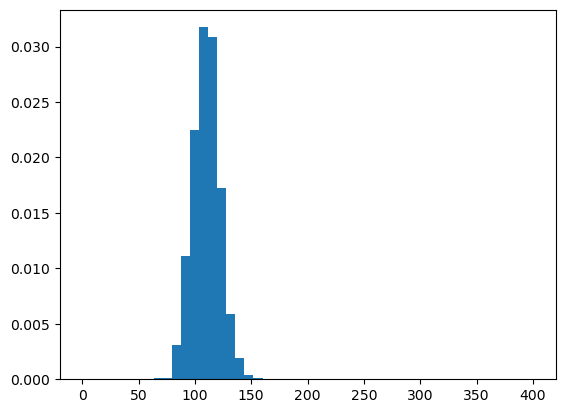

In [8]:
sta_types = ['binary',"int"]
dyn_types = ['continuous']*len(dyn[0].columns)
dynamics = pd.concat(dyn)
seq_len = [len(x) for x in dyn]
sta["seq_len"]=np.array(seq_len)

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(seq_len, range=(0,400), bins=50, density=True)
plt.show()

In [16]:
d_P.transform(dyn[0])[0].std(axis=0)

array([0.4400284 , 0.42192423], dtype=float32)

In [10]:
from general.missingprocessor import Processor
d_P = Processor(dyn_types, use_pri='time')
s_P = Processor(sta_types)
d_P.fit(dynamics)
s_P.fit(sta)

all values are integer
time 1 None int None
IGNORE
S1 1 0.2527850633474105 continuous None
IGNORE
S2 1 0.38065347855078907 continuous None
IGNORE
Label 1 None binary None
seq_len 1 None int None
IGNORE


In [17]:
def build_dataset(sta, dyn, seq_len):
    s = s_P.transform(sta)
    d_lis=[d_P.transform(ds) for ds in dyn]
    d = [x[0].tolist() for x in d_lis]
    lag = [x[1].tolist() for x in d_lis]
    mask = [x[2].tolist() for x in d_lis]
    times = [x[-1].tolist() for x in d_lis]
    priv = [x[3].tolist() for x in d_lis]
    nex = [x[4].tolist() for x in d_lis]
    label = [float(x[-2]) for x in s] 
    from fastNLP import DataSet
    dataset = DataSet({"seq_len": seq_len, 
                       "dyn": d, "lag":lag, "mask": mask,
                       "sta": s, "times":times, "priv":priv, "nex":nex, "label": label
                      })
    return dataset

dataset = build_dataset(sta, dyn, seq_len)

In [18]:
dataset

+---------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------+
| seq_len | dyn          | lag          | mask         | sta          | times        | priv         | nex          | label |
+---------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------+
| 129     | [[0.04994... | [[-1.7191... | [[1.0, 0.... | [0.      ... | [[-1.7191... | [[0.0, 0.... | [[0.0, 0.... | 0.0   |
| 97      | [[0.71085... | [[-1.5588... | [[1.0, 1.... | [ 0.     ... | [[-1.5588... | [[0.0, 0.... | [[0.0, 0.... | 0.0   |
| 101     | [[0.0, 0.... | [[-1.6368... | [[0.0, 1.... | [ 0.     ... | [[-1.6368... | [[0.0, 0.... | [[0.0, 0.... | 0.0   |
| 101     | [[0.72751... | [[-1.6758... | [[1.0, 0.... | [ 0.     ... | [[-1.6758... | [[0.0, 0.... | [[0.0, 0.... | 0.0   |
| 95      | [[0.28242... | [[-1.7061... | [[1.0, 1.... | [ 0.     ... | [[-1.7061... | [[0.0, 0.... | [[0.0, 0.... | 0.0   |


In [19]:
test_sta, test_dyn = sta, dyn
test_seq_len = [len(x) for x in test_dyn]
test_sta["seq_len"]=np.array(test_seq_len)
val_set = build_dataset(test_sta, test_dyn, test_seq_len)

In [11]:
finaldic = {
    "train_set": dataset,
    'raw_set': (sta,dyn),
    'test_set': (test_sta,test_dyn),
    'val_set': val_set,
    "dynamic_processor": d_P,
    "static_processor":s_P
}
import pickle
from utils.general import make_sure_path_exists
make_sure_path_exists("./data/hkgan/")
with open("./data/physio_data/sine_irreg.pkl", "wb") as f:
    pickle.dump(finaldic, f)
